The dataset contains Twitter data, including tweet IDs, entities mentioned in the tweets, and the sentiment associated with those tweets. There are three sentiment classes: positive, negative, and neutral. Tweets that don't pertain to the mentioned entity are considered neutral.

Here's a breakdown of the dataset columns:

-> Tweet ID: The unique identifier for each tweet.

-> Entity: The subject or topic that the tweet is discussing.

-> Sentiment: The emotional tone expressed in the tweet, which can be positive, negative, neutral, or marked as irrelevant if it doesn't relate to the mentioned entity.

->Tweet Content: The actual text of the tweet.

* Importing libraries

In [369]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import warnings
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=3000)

warnings.filterwarnings('ignore')

In [370]:
col_names = ['ID', 'Entity', 'Sentiment', 'Content']

In [371]:
train = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv",names=col_names)
train.sample(5)

,ID,Entity,Sentiment,Content
63868,7744,MaddenNFL,Irrelevant,Say I love you @katienolan but also I think @P...
38823,5462,Hearthstone,Irrelevant,Another participant of the Hearthstone Polish ...
46087,11910,Verizon,Irrelevant,How about reacting to your Internet child @ Ya...
32114,7511,LeagueOfLegends,Irrelevant,"Maybe, but sometimes the feeling of a little b..."
37949,5307,Hearthstone,Neutral,by


In [372]:
test = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv",names=col_names)
test.sample(5)

,ID,Entity,Sentiment,Content
460,12514,WorldOfCraft,Neutral,"Yup, There's a Zombie Plague in World of Warcr..."
32,7024,johnson&johnson,Negative,"Johnson & Johnson, knowingly sold baby powder ..."
941,8451,NBA2K,Negative,It’s ridiculous and embarrassing how unplayabl...
110,10011,PlayerUnknownsBattlegrounds(PUBG),Neutral,one of the best kpop moments was at Isac 2020 ...
748,6143,FIFA,Positive,Not gonna lie. The FIFA 2021 and PS5 combo is ...


In [373]:
train.shape

(74682, 4)

# 2. Data Preprocessing

In [374]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         74682 non-null  int64 
 1   Entity     74682 non-null  object
 2   Sentiment  74682 non-null  object
 3   Content    73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [375]:
# checking null values
train.isnull().sum()

ID             0
Entity         0
Sentiment      0
Content      686
dtype: int64

In [376]:
train.dropna(subset=['Content'], inplace=True)

In [377]:
# checking duplicate values
train.duplicated().sum()

2340

In [378]:
# replacing irrelavant with neutral
train['Sentiment'] = train['Sentiment'].replace('Irrelevant', 'Neutral')
test['Sentiment'] = test['Sentiment'].replace('Irrelevant', 'Neutral')

In [379]:
train.head()

,ID,Entity,Sentiment,Content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [380]:
# checking duplicate values
train.duplicated().sum()

2340

In [381]:
# dropping duplicates
train = train.drop_duplicates(keep='first')

In [382]:
train.duplicated().sum()

0

In [383]:
train.shape

(71656, 4)

In [384]:
train.head()

,ID,Entity,Sentiment,Content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


# 3. Exploratory Data Analysis (EDA)

In [385]:
train['Sentiment'].value_counts()

Sentiment
Neutral     30245
Negative    21698
Positive    19713
Name: count, dtype: int64

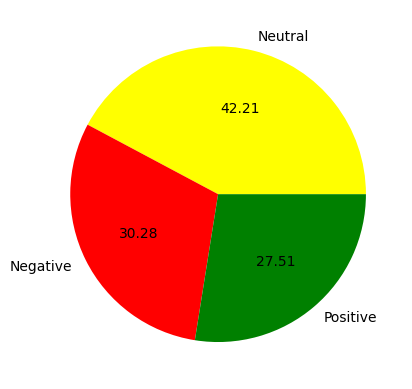

In [386]:
plt.pie(train['Sentiment'].value_counts(), labels=['Neutral','Negative','Positive'],autopct='%0.2f',colors=['yellow','red','green'])
plt.show()

In [387]:
# Data is imbalanced
# hence we will give more importance to accuracy than precision

In [388]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [389]:
train['num_char'] = train['Content'].apply(len) # no of characters of each text

In [390]:
train.head()

,ID,Entity,Sentiment,Content,num_char
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,53
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,51
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,50
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,51
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,57


In [391]:
# number of words
train['num_words'] = train['Content'].apply(lambda x: len(nltk.word_tokenize(x)))

In [392]:
train.head()

,ID,Entity,Sentiment,Content,num_char,num_words
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,53,11
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,51,13
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,50,11
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,51,11
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,57,13


In [393]:
# number of sentences
train['num_sentences'] = train['Content'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [394]:
train.head()

,ID,Entity,Sentiment,Content,num_char,num_words,num_sentences
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,53,11,1
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,51,13,1
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,50,11,1
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,51,11,1
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,57,13,1


In [395]:
# data description
train[['num_char','num_words','num_sentences']].describe()

,num_char,num_words,num_sentences
count,71656.000000,71656.000000,71656.000000
mean,110.538127,22.976471,1.953081
std,79.409848,17.180371,1.635957
min,1.000000,0.000000,0.000000
25%,49.000000,10.000000,1.000000
50%,93.000000,19.000000,1.000000
75%,155.000000,32.000000,2.000000
max,957.000000,198.000000,33.000000


<Axes: xlabel='num_char', ylabel='Count'>

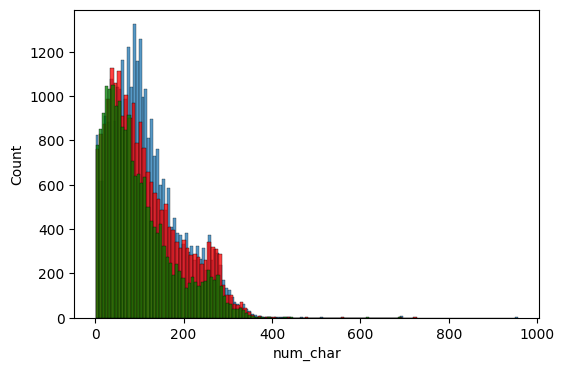

In [396]:
plt.figure(figsize=(6,4))
sns.histplot(train[train['Sentiment'] == 'Neutral']['num_char'])
sns.histplot(train[train['Sentiment'] == 'Negative']['num_char'], color='red')
sns.histplot(train[train['Sentiment'] == 'Positive']['num_char'], color='green')

<Axes: xlabel='num_words', ylabel='Count'>

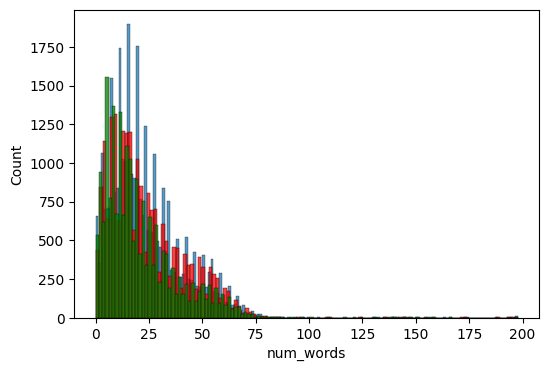

In [397]:
plt.figure(figsize=(6,4))
sns.histplot(train[train['Sentiment'] == 'Neutral']['num_words'])
sns.histplot(train[train['Sentiment'] == 'Negative']['num_words'], color='red')
sns.histplot(train[train['Sentiment'] == 'Positive']['num_words'], color='green')

In [398]:
df=train.drop(['ID','Entity'],axis=1)

In [399]:
df.head()

,Sentiment,Content,num_char,num_words,num_sentences
0,Positive,im getting on borderlands and i will murder yo...,53,11,1
1,Positive,I am coming to the borders and I will kill you...,51,13,1
2,Positive,im getting on borderlands and i will kill you ...,50,11,1
3,Positive,im coming on borderlands and i will murder you...,51,11,1
4,Positive,im getting on borderlands 2 and i will murder ...,57,13,1


In [400]:
# Perform one-hot encoding
df_encoded = pd.get_dummies(df, columns=['Sentiment'],drop_first=True)
df_encoded['Sentiment_Neutral'] = df_encoded['Sentiment_Neutral'].astype(int)
df_encoded['Sentiment_Positive'] = df_encoded['Sentiment_Positive'].astype(int)

In [401]:
df_encoded=df_encoded.drop(['Content'],axis=1)

<Axes: >

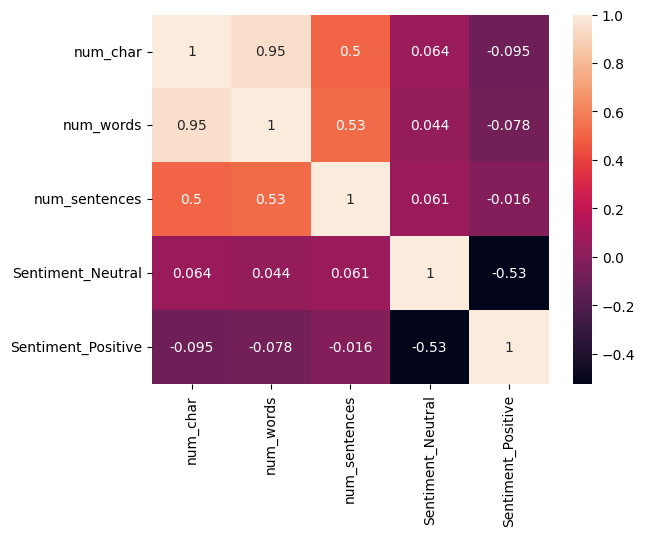

In [402]:
sns.heatmap(df_encoded.corr(),annot=True)

# 4. Text Preprocessing
* Lower Case
* Tokenization
* Removing Special Character
* Removing stop words and puntuations
* Stemming

In [403]:
from nltk.corpus import stopwords
import string # for punctuation
# string.punctuation
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
            
    text = y[:] # list is mutable, so you have to do cloning, else if you clear y, text gets cleared too
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
    
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
        
    return " ".join(y)

In [404]:
# Perform Label encoding
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['Sentiment'])

In [405]:
df.head()

,Sentiment,Content,num_char,num_words,num_sentences,sentiment_encoded
0,Positive,im getting on borderlands and i will murder yo...,53,11,1,2
1,Positive,I am coming to the borders and I will kill you...,51,13,1,2
2,Positive,im getting on borderlands and i will kill you ...,50,11,1,2
3,Positive,im coming on borderlands and i will murder you...,51,11,1,2
4,Positive,im getting on borderlands 2 and i will murder ...,57,13,1,2


In [406]:
df['transformed_text'] = df['Content'].apply(transform_text)

In [407]:
df.head()

,Sentiment,Content,num_char,num_words,num_sentences,sentiment_encoded,transformed_text
0,Positive,im getting on borderlands and i will murder yo...,53,11,1,2,im get borderland murder
1,Positive,I am coming to the borders and I will kill you...,51,13,1,2,come border kill
2,Positive,im getting on borderlands and i will kill you ...,50,11,1,2,im get borderland kill
3,Positive,im coming on borderlands and i will murder you...,51,11,1,2,im come borderland murder
4,Positive,im getting on borderlands 2 and i will murder ...,57,13,1,2,im get borderland 2 murder


In [408]:
from wordcloud import WordCloud
wc = WordCloud(width=1000, height=1000, min_font_size=10, background_color='black')

In [409]:
condition = (df['sentiment_encoded']==0)

# Generate the word cloud for "transformed_text" when both conditions are met
wcNeutral = WordCloud().generate(df[condition]['transformed_text'].str.cat(sep=" "))

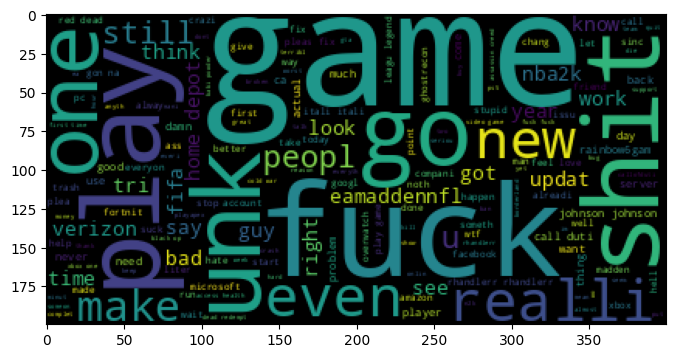

In [410]:
plt.figure(figsize=(8,8))
plt.imshow(wcNeutral)

In [411]:
condition = (df['sentiment_encoded']==1)

# Generate the word cloud for "transformed_text" when both conditions are met
wcNegative = WordCloud().generate(df[condition]['transformed_text'].str.cat(sep=" "))

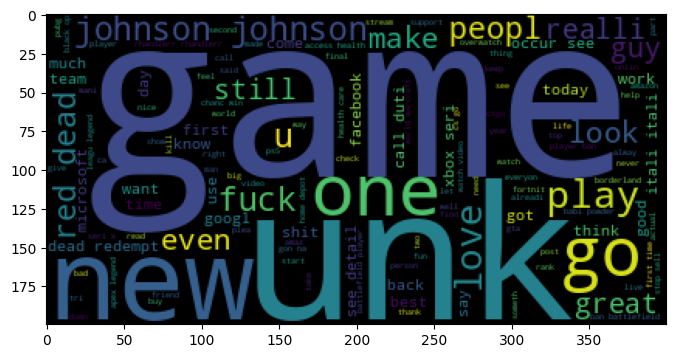

In [412]:
plt.figure(figsize=(8,8))
plt.imshow(wcNegative)

In [413]:
condition = (df['sentiment_encoded']==2)

# Generate the word cloud for "transformed_text" when both conditions are met
wcPositive = WordCloud().generate(df[condition]['transformed_text'].str.cat(sep=" "))

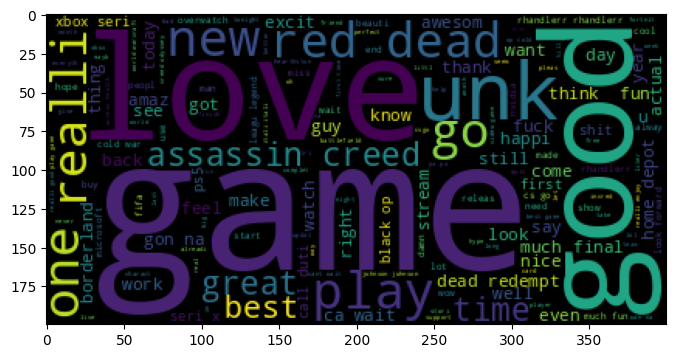

In [414]:
plt.figure(figsize=(8,8))
plt.imshow(wcPositive)

# 5. Building the Model

In [415]:
df=df.drop(['Sentiment'],axis=1)

In [416]:
X = tfidf.fit_transform(df['transformed_text']).toarray()

In [417]:
print(X.shape)

(71656, 3000)


In [418]:
y = df['sentiment_encoded'].values

In [419]:
print(y.shape)

(71656,)


In [420]:
from sklearn.model_selection import train_test_split

In [421]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=2)

# 6. Evaluation

In [422]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

bnb = BernoulliNB()

In [423]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

bnb = BernoulliNB()

In [424]:
# TFIDF Vectorizer - BernoulliNB
bnb.fit(X_train, y_train)
y_pred = bnb.predict(X_test)
print(precision_score(y_test,y_pred,average=None))

[0.71112255 0.68406285 0.54860839]


In [426]:
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LogisticRegression 
# Create a pipeline with just the logistic regression classifier
pipeline = Pipeline([
    ('lr_clf', LogisticRegression(solver='liblinear'))
])

# defining the hyperparameter grid for logistic regression (C parameter)
params = {'lr_clf__C': [1, 5, 10]}

grid_cv_pipe = GridSearchCV(pipeline, param_grid=params, cv=3, scoring='accuracy', verbose=1)
grid_cv_pipe.fit(X_train, y_train)
print('Optimized Hyperparameters:', grid_cv_pipe.best_params_)

pred = grid_cv_pipe.predict(X_test)
print('Optimized Accuracy Score: {0: .3f}'.format(accuracy_score(y_test, pred)))

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Optimized Hyperparameters: {'lr_clf__C': 10}
Optimized Accuracy Score:  0.695


In [427]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.71      0.63      0.67      4391
           1       0.68      0.61      0.64      6020
           2       0.55      0.71      0.62      3921

    accuracy                           0.64     14332
   macro avg       0.65      0.65      0.64     14332
weighted avg       0.66      0.64      0.64     14332

